In [1]:
#library imports
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import aslearn

In [2]:
#helper functions
def show_confusion(y, preds, one_class=False, vmin=0):
    stats = aslearn.Utils.confusion(y, preds)
    ax = sns.heatmap(stats['confusion matrix'], linewidth = 0.5, vmin=vmin)
    plt.show()

    print(f"Accuracy: {round(stats['accuracy']*100,2)}%")
    if one_class:
        print(f"""Single Class:
        Precision: {round(stats['class']['precision'][1],4)}
        Recall: {round(stats['class']['recall'][1],4)}
        F1: {round(stats['class']['f1'][1],4)}""")
    else:
        print(f"""Weighted:
        Precision: {round(stats['weighted avg']['precision']*100,2)}
        Recall: {round(stats['weighted avg']['recall']*100,2)}
        F1: {round(stats['weighted avg']['f1']*100,2)}""")

def show_cost(clf, key, start=0, end=-1):
    j = clf.clfs[key].J_history
    x = list(range(len(j)))
    sns.regplot(x=x[start:end],y=j[start:end], line_kws={"color": "red"})
    plt.show()

def show_all_cost(logistic_regression):

    rows = 2
    columns = 5
    fig, axs = plt.subplots(rows,columns, figsize=(10, 4))

    indx=0
    for i in range(rows):
        for j in range(columns):
            y = logistic_regression.clfs[indx].J_history
            x = list(range(len(y)))
            axs[i,j].plot(x,y)
            indx += 1
    plt.tight_layout()
    plt.show()

# Overview:
The goal of this project is to create a fully featured production quality machine learning library that has support for multiple machine learning models.
While there are multiple libraries already available, building one from the ground up will help me learn how the models work under the hood, and put into practice object orientated methodologies.

This workbook is mainly to test the functionality the library.

**aslearn** is the name of my toy ML library.  It is named aslearn in homage to scikit-learn (sklearn) replacing “sk” with my initials “as”-- very creative I know. As the name might suggest, aslearn been developed to function with a similar API to scikit-learn, with a few extra features that I thought would be interesting.  I have not looked at the scikit-learn source code or documentation for reference and have reversed engineered its functionality solely from memory, so some things may be a bit different.  Because aslearn is implemented completely in python using only the numpy library, training and prediction performance will likely be worse than other libraries that use C under the hood.  I have vectorized the math as much as I could with numpy to keep performance reasonable, but the main goal of the project is not bleeding edge performance.

# Glossary
This implementation has some built in functionality that can be accessed through the key word arguments.  Some of these functions are not available in other libraries so their use may not be intuitive at first.

**Kwarg Features:**
- **keep_best:** This is a 'poor-mans' early stopping.  The values of theta are stored for the lowest value of J during the training cycle.  After all epochs are completed, theta is replaced by the theta values corresponding to the lowest value of J.  This could lead to over-fitting however it seems to have helped performance and consistency in this case.
- **feature_scaling:** There is a built in feature scaling class which is accessible through a fit and transformed in the Utils class, the SGD Class has access to this.  When set to True, the training data is automatically scaled before being passed through.  The fitted scaler class is stored in the classifier and when the predict method is called, the input is automatically scaled using the stored values learned during training.  I find this method simplifies the processing pipeline.
- **shuffle:** Shuffle will shuffle the training data after each epoch.  Doing this helps keep descent smooth by randomizing the data that is presented in each batch.

**Other Implementation Details**

- **Single/Multi-Class:**  The logistic regression class will detect if the training set is multi or single class based on the values in y.  In the single class case, one classifier will be trained.  In the multi-class n classifiers will be trained for n classes.  The API for both remains the same.
- **Label Encoding:** The logistic regression class handles y input by using the label encoder class.  It will assign all labels to an index and handle translating inputs between the key for internal use, and the value for when it give the data back.  This simplifies things for the user as they do not need to worry about converting their y values back and forth themselves



**Terms:**

In this workbook I may refer to some terms by the Greek symbols that are used to notate them in the mathematical equations.
- **X:**  The matrix that holds the vectors of the training samples
- **y:** The vector that holds the class identities for the vectors in X
- **alpha:** The learning rate term
- **theta:** the vector of model coefficients
- **J:** The cost.  Cost is a measure of error between a set of predictions and the corresponding true values 
- **Class, Target, Label:** Used somewhat interchangeable.  These are the distinct values found in y
- **llambda:** This refers to the lambda regularization term.  "Lambda" is reserved in python for anonymous functions, so an extra l is added on the front.  In off screen hyper-parameter tuning, overfitting did not seem to be a big issue, so regularization has been disabled.  This may be something worth tuning but for the sake of brevity we will not
- **n_epochs:** The amount of times the full dataset will be iterated over during training
- **batch_size:** The size of each set of training data that will be used to minimize J in relation to theta

# Methodology:
For the remainder of this workbook, I will work through solving the MNIST problem using a logistic regression classifier to showcase the functionality of the aslearn library, as well as the thought process for tackling this kind of problem.

# MNIST Dataset:
**MNIST** is a dataset of hand drawn numbers between Zero and Nine, as well as the labels for those digits.  It has been referred to as the "Hello World" of machine learning.  Because it is such a common dataset, it is a great place to start to make sure that the library is functioning correctly.

X Shape: 784
y Shape: 1
Samples: 70000
y Samples: ['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7']
X Samples (rendered):


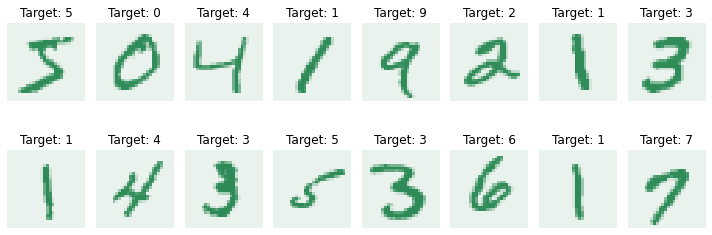

In [3]:
#load and visualize mnist
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(f'X Shape: {X.shape[1]}\ny Shape: {1}\nSamples: {len(y)}\ny Samples: {y[0:16]}\nX Samples (rendered):')

rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X[indx]
        axs[i,j].imshow(np.reshape(X[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
plt.show()

The version of MNIST we are using is already broken into X and y for us:

- **X:** The pixel values of the and written numbers.  They are unrolled into a single row vector with values between 0 and 255, representing white intensity.
- **y:** A string value of the class names.  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'

There are 70,000 samples for us to use.  We will begin by splitting them into 3 sets:

- **Train:** (60,000 samples) will be used in regression to fit the model parameters
- **Test:** (5,000 samples) Will be used to test the models and tweak hyper parameters
- **Validation:** (5,000 samples) Will be used for the final validation to gauge how the model will perform in the wild.  We use this because during training we will be using feedback from the Test set to make changes to the hyper-parameters, so the models will be somewhat fitted to the test set as a result.  Val will give a true sense of model performance.

In [4]:
#train test split
train_samples = 60000
test_val_samples = (len(y) - 60000) // 2
(X_train, y_train), (X_test, y_test) = aslearn.Utils.train_test_split(X, y, train_samples)
(X_test, y_test), (X_val, y_val) = aslearn.Utils.train_test_split(X_train, y_train, test_val_samples)

# Training

Our eventual goal will be to train a classifier that can predict all classes, but we'll start small.  We will first train a single class classifier that can predict only a single term.
This will be a lot faster to train than the full classifier, so we will be able to play around with the hyper parameters and not have to wait long to check the results.


# '2' Classifier
We will train on a Logistic Regression classifier on the label '2' using stochastic gradient descent (SGD) with small batch's of 500 across 5 epochs.

SGD is a relatively fast optimizer so it should hopefully converge quickly.  We'll watch the cost of the model (J) as it trains to make sure that we have good settings for our hyper parameters.



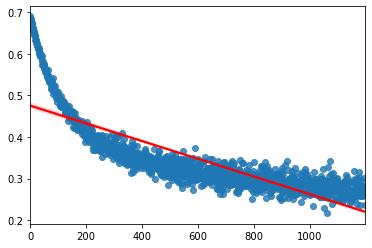

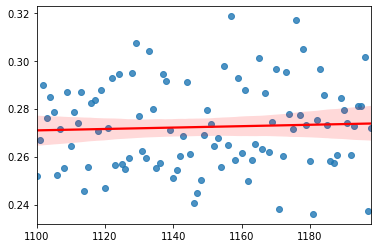

In [5]:
label = '2'
alpha = .01 #learning rate
llambda = 0 #regularization term.  0 disables regularization
n_epochs = 10 #amount of times the full dataset is trained on
batch_size = 500 #amount of samples in each training batch
keep_best = True #remember the best values of theta that minimizes J across all ephocs and use it after training is complete

clf = aslearn.Logistic_Regression()
clf.fit(X_train, y_train == label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, keep_best=keep_best, shuffle=True)

show_cost(clf, 0)
show_cost(clf, 0, -100)

The above graphs show the value of J after each update to theta.  As the cost goes down, it means the accuracy of the classifier on the training set is increasing.  The goal is to minimize J as much as possible until it converges on the lowest value of J.

We can see in the first figure that J is decreasing over time, however it's flattening out around 2.5 and not going down much further for each training cycle.  We could leave this running for many more epochs and likely converge, but this is slow.  We will be training multiple classifiers so we want to make sure we're converging quickly so we do not have to wait a long time.

Let’s start by trying a relatively high value of alpha and see what happens.

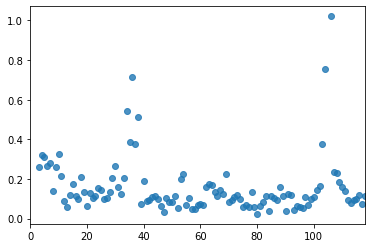

In [6]:
label = '2'
alpha = 100.
n_epochs = 1

clf = aslearn.Logistic_Regression()
clf.fit(X_train, y_train == label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, keep_best=keep_best, shuffle=True)

show_cost(clf, 0)

The value of J is all over the graph, meaning the model isnt converging at all.  When alpha is too high the model over corrects on each training cycle and ends up overshooting the optimal values.  We want to see a nice smooth line.

The best practice is to start a bit high and adjust alpha in steps of about one third until the model starts converging:

- ...
- 100
- 60
- 30
- 10
- 6
- 3
- 1
- 0.6
- 0.3
- 0.1
- 0.06
- 0.03
- 0.01
- ...

We know that 100 is too big, and 0.01 is too small, so we have a relatively small window to check.  Let’s adjust the learning rate until we start to see a nice descent.

Offscreen a alpha value of 60 was tested and did not converge.

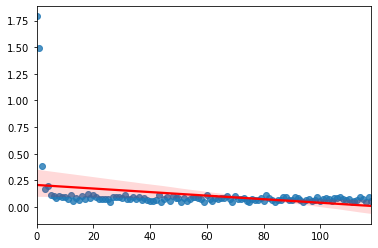

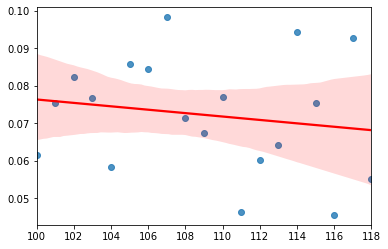

In [7]:
alpha = 30.

clf = aslearn.Logistic_Regression()
clf.fit(X_train, y_train == label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, keep_best=keep_best, shuffle=True)

show_cost(clf, 0)
show_cost(clf, 0, 100)

30 Seems ok, but it is usually a good idea to go one step further down.  A high learning rate can still cause the model to not converge meaning we won’t get optimal performance.  We also have to consider that we're going to be training other classifiers, and it will be better to be a bit more conservative in case we're right on the edge.

Let’s go with 10.

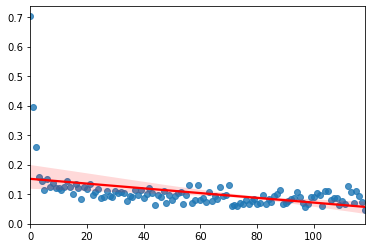

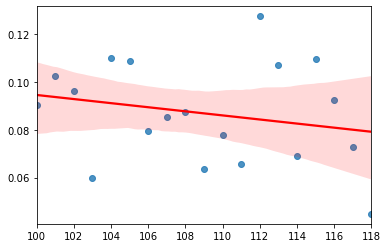

In [8]:
alpha = 10.

clf = aslearn.Logistic_Regression()
clf.fit(X_train, y_train == label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, shuffle=True)

show_cost(clf, 0)
show_cost(clf, 0, 100)

An alpha of 10 looks just right, the model is converging at a good rate.  The trend is still down and to the right so we likely can achieve better performance if we train on more epochs.

First let’s see how the model is performing on the test set after just one epoch.

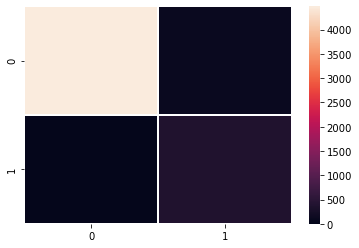

Accuracy: 97.04%
Single Class:
        Precision: 0.9146
        Recall: 0.7684
        F1: 0.8352


In [9]:
#plot confusion matrix
show_confusion(y_test==label, clf.predict(X_test), one_class=True)

97% accuracy, that looks amazing! But we need to remember that '2's only make up about 10% of the training data.  What would happen if we were to not use the model and instead just predict that the answer is false (not '2') on every test case?

# Hard Coded Predictions

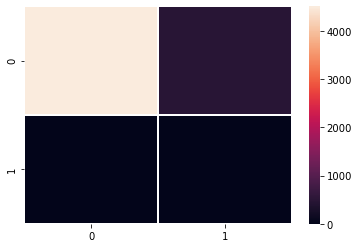

Accuracy: 90.24%
Single Class:
        Precision: 0.0
        Recall: 0.0
        F1: 0.0


In [10]:
#plot confusion matrix (always predict false)
show_confusion(y_test==label, [False for _ in y_test], one_class=True)

Because 2's only make up about 10% of the data, predicting false on all samples result in about 90% accuracy.  97.59% still means the model is performing better much better than the hard coded value, but it’s good to apply some Bayesian reasoning to keep us objective.  If we had less than 90% we should be concerned.

For fun lets see what happens when we always predict true.

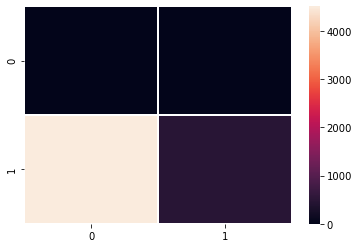

Accuracy: 9.76%
Single Class:
        Precision: 0.0976
        Recall: 1.0
        F1: 0.1778


In [11]:
#plot confusion matrix (always predict True)
show_confusion(y_test==label, [True for _ in y_test], one_class=True)

**Recall** is a perfect score of 1!  For every positive case it has predicted them correctly.  Of course it has also predicted True on all the Falses, so **Precision** is very poor.

**F-Score** (F1) combines Precision and Recall. We see that the model scores a respectable .9 and the hard coding values scores very low (0 and 0.17 respectively).  F1 is usually a better indicator of model performance but you may need to be careful with this as well depending on the purpose of your model.

## Continued Training
This implementation of the logistic regression class supports warm starting.  This means we can continue training the model using different hyper parameters.
Lets keep training using SGD and see if J continues to decrease

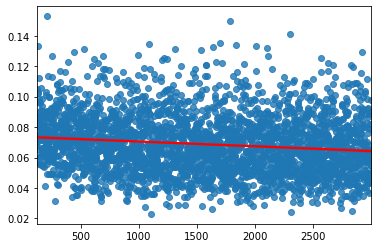

In [12]:
plt_start = len(clf.clfs[0].J_history)

n_epochs = 24
clf.fit(X_train, y_train == label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, shuffle=True, keep_best=keep_best, warm_start=True)

show_cost(clf, 0, plt_start)

We've now trained for a total of 25 epochs.  The cost is still trending down, but it is very slow, and there is a lot of noise.  Our learning rate may be too high for the model to converge.  We could adjust that and continue training, but instead let’s try changing the batch_size to cover the whole training set.  This will turn our SGD optimizer into Batch Gradient Decent (BGD).

BGD is much slower than SGD because it has to process the entire training set for each time it updates the value of J, but it has the advantage that each training cycle will bring it closer to the optima.  We should see a consistent descent.

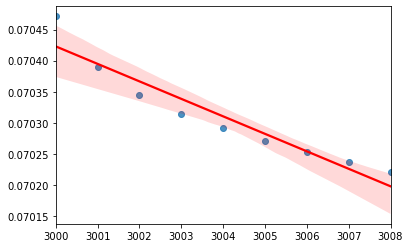

In [13]:
plt_start = len(clf.clfs[0].J_history)
alpha = .3
n_epochs = 10
batch_size = 60000

clf.fit(X_train, y_train==label, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, keep_best=keep_best, warm_start=True)

show_cost(clf, 0, plt_start)

Cost is looks to be decreasing but look at the y axis values.  The change after each epoch is miniscule. Lets zoom out a bit to get a better perspective.

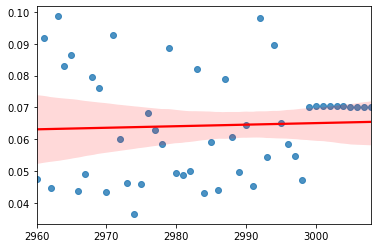

In [14]:
#plot J
show_cost(clf, 0, plt_start-40)

By zooming out we can see that J has basically flat lined in the grand scheeme of things.
At such a slow rate that we're not likely to get much more performance out of the training any time soon.
	
Really, we haven’t made any real progress since after the initial 25 SGD epochs.  Let’s remember this for when we train the 10-class classifier.  We can skip the BGD step.

Now lets see how the updated model scores on the test data again.

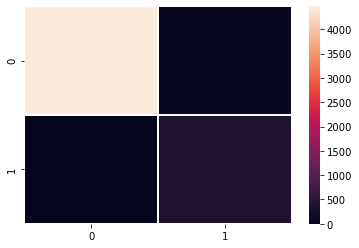

Accuracy: 97.46%
Single Class:
        Precision: 0.9093
        Recall: 0.8217
        F1: 0.8633


In [15]:
#plot confusion matrix
show_confusion(y_test==label, clf.predict(X_test), one_class=True)

97% accuracy is a great start and we've learned a lot about how the hyper parameters interact with the data.

lets take what we've learned and apply it to classifying across all the labels.

## Training on all classes
There are 10 classes in the data:
- '0'
- '1'
- '2' 
- '3' 
- '4' 
- '5' 
- '6' 
- '7' 
- '8' 
- '9'

Because we want to predict multiple classes, we will train 10 classifiers.  Each will predict true or false (as a probability of true) for one label.  The classifier with the greatest probability will decide the class for the entire ensemble.

The implementation of logistic regression automatically detects that there are more than one class and will handle the model and predication management for us.

We will take what we learned in the simplified '2' classifier case and use the same hyper parameters for the multi-class case.

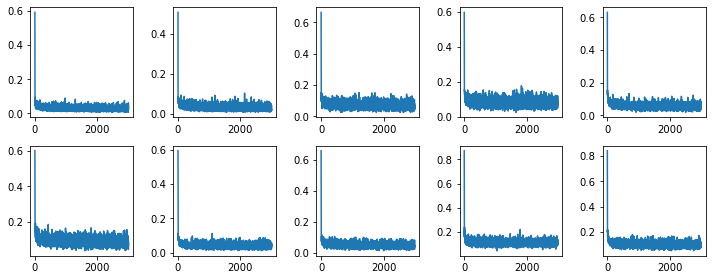

In [16]:
alpha = 10.
n_epochs = 25
batch_size = 500

clf = aslearn.Logistic_Regression()
clf.fit(X_train, y_train, alpha=alpha,
        n_epochs= n_epochs, batch_size = batch_size,
        llambda=llambda, feature_scaling=True, keep_best=keep_best, shuffle=True)

show_all_cost(clf)

The J curve's look healthy for all the classifiers, and all seem the be essentially converged.  It looks like the hyperparameters we found in the simplified problem are applicable across all classes.  Let’s check the models overall performance:

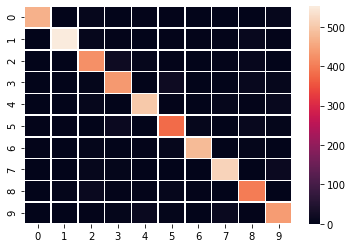

Accuracy: 92.08%
Weighted:
        Precision: 92.04
        Recall: 92.08
        F1: 92.04


In [17]:
#plot confusion matrix
preds = clf.predict(X_test)
show_confusion(y_test, preds)

The confusion matrix looks good, we have high values across the diagonal (true positives) and low values everywhere else (false positives and false negatives).

We're getting 92% accuracy when predicting across all classes!  Remember that this time we are predicating on all classes, not just one so predicting '2' every time would result in about 10% accuracy.  This is great.  We can see a very good F1 score as well.

Because we've used the test set to tune the hyper parameters, we will have fit our models to that data.

Let’s check against the validation set which hasn't been biased at all to make sure we'll get similar results with brand new data.

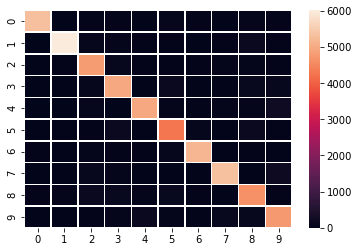

Accuracy: 91.47%
Weighted:
        Precision: 91.43
        Recall: 91.47
        F1: 91.43


In [18]:
#plot confusion matrix
preds = clf.predict(X_val)
show_confusion(y_val, preds)

91% is a little bit less than the test set, but not by much.  The model is generalizing well.  The highest realistic accuracy for a Logistic Model on MNIST is about 92%, so the model is performing well!

Let’s take a peek under the hood.  Below are the values of theta for each classifier visuallized.

Theta is the coefficients of the model; these are the numbers used to decide what class the image belongs too.

Blue indicates a positive correlation for a pixel to increase probability of the class, red is a negative correlation.

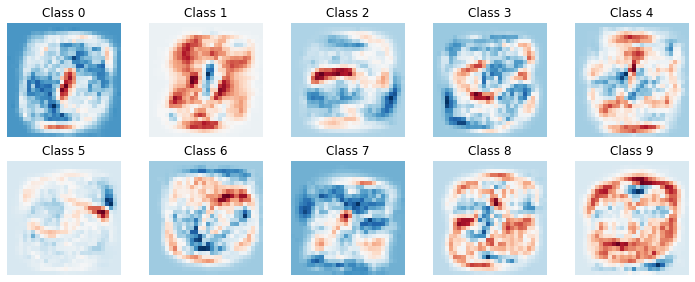

In [19]:
#plot thetas
rows = 2
columns = 5
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        key = clf.ohe.keys[indx]
        theta = np.reshape(clf.clfs[indx].theta[1:], (28,28))
        scale = np.abs(theta).max()
        axs[i,j].imshow(theta, interpolation='nearest', cmap=plt.cm.RdBu)
        axs[i,j].axis('off')
        axs[i,j].title.set_text(f'Class {key}')
        indx += 1
plt.tight_layout()
plt.show()

We can seem some familiar shapes.  0 has a nice blue circle with a red space in the middle.  1 has a horizontal line in the middle.

# Conclusion

MNIST is a relatively simple problem to solve, and higher accuracies are also possible using more advance techniques such as convolutional networks.

The goal of the project was to create and demonstrate a fully featured machine learning library that functions as expected which I hope I have done.  Please remember to take a look at the aslearn.py file to see the implementation as this is where most of the work has been done.

# Thank you!